In [1]:
import json
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings

In [2]:
train = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))


In [3]:
labels = []
tokens = []
for i in train:
    labels.extend([j for j in i['labels'] if j!='O'])
    tokens.extend([k for j, k in zip(i['labels'],i['tokens']) if j!='O'])


<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#5642C5;
       font-size:110%;
       font-family:Verdana;
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:white;"> Eğer etiket 'O' değilse, yalnızca bu etiketi labels listesine ekliyor. labels listesi 'O' olmayan tüm etiketleri içerir. tokens listesi, bu 'O' olmayan etiketlere ait olan tokenları içerir. 

In [4]:
data = pd.DataFrame({'labels':labels,'tokens':tokens})
data.head()

,labels,tokens
0,B-NAME_STUDENT,Nathalie
1,I-NAME_STUDENT,Sylla
2,B-NAME_STUDENT,Nathalie
3,I-NAME_STUDENT,Sylla
4,B-NAME_STUDENT,Nathalie


# Label Distribution

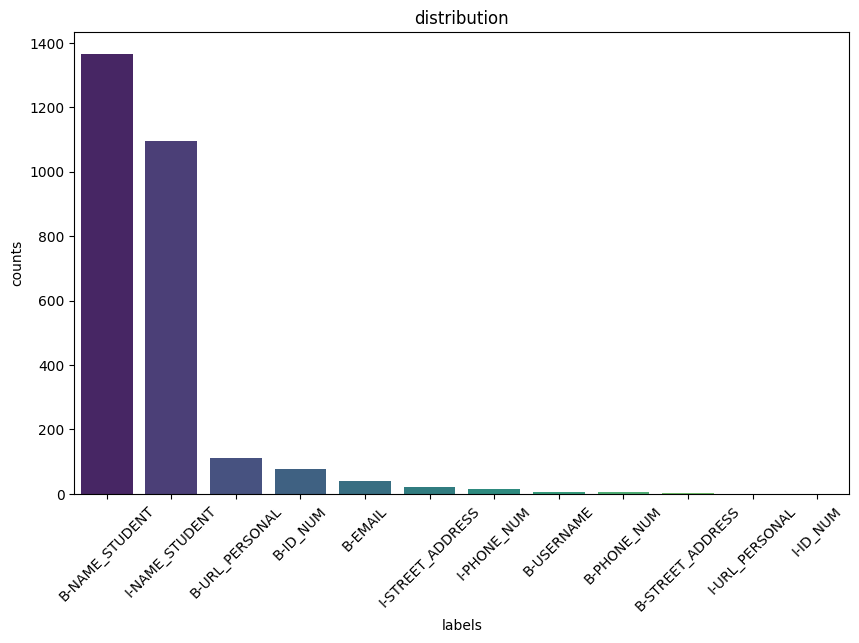

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.DataFrame({'labels': labels, 'tokens': tokens})

label_counts = data['labels'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('distribution')
plt.xlabel('labels')
plt.ylabel('counts')
plt.xticks(rotation=45)
plt.show()


# Distribution of B and I Labels

In [6]:
data['BIO'] = data['labels'].apply(lambda x: x[0])

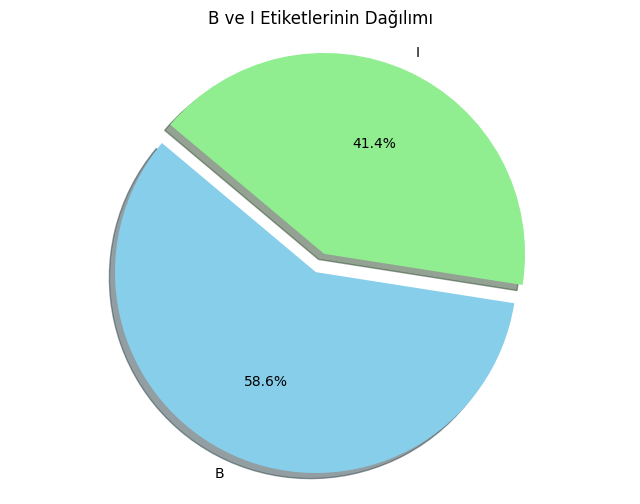

In [7]:
import matplotlib.pyplot as plt

# Veri çerçevesinin başlangıç kısmını oluşturma
data = pd.DataFrame({'labels': labels, 'tokens': tokens})

# B ve I etiketlerinin sayısını hesapla
b_count = data[data['labels'].str.startswith('B-')]['labels'].count()
i_count = data[data['labels'].str.startswith('I-')]['labels'].count()

# Pie chart oluştur
labels = ['B', 'I']
sizes = [b_count, i_count]
colors = ['skyblue', 'lightgreen']
explode = (0.1, 0)  # İlk dilim (B) birazcık dışa doğru taşsın

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('B ve I Etiketlerinin Dağılımı')
plt.axis('equal')  # Dairesel şeklin korunması için
plt.show()


In [8]:
data['BIO'] = data['labels'].apply(lambda x: x[0])


In [9]:
BIO_list = data['BIO']
lengths = []
ids = []
for i, j in enumerate(BIO_list):
    if i == 0:
        ids.append(0)
        lengths.append(1)
    else:
        if (j == 'I'):
            ids.append(ids[i-1])
            lengths.append(lengths[i-1]+1)
        else:
            ids.append(ids[i-1]+1)
            lengths.append(1)
data['lengths'] = lengths
data['ids'] = ids
data

,labels,tokens,BIO,lengths,ids
0,B-NAME_STUDENT,Nathalie,B,1,0
1,I-NAME_STUDENT,Sylla,I,2,0
2,B-NAME_STUDENT,Nathalie,B,1,1
3,I-NAME_STUDENT,Sylla,I,2,1
4,B-NAME_STUDENT,Nathalie,B,1,2
...,...,...,...,...,...
2734,B-ID_NUM,IV-8322,B,1,1602
2735,B-ID_NUM,IV-8322,B,1,1603
2736,B-ID_NUM,Z.S.,B,1,1604
2737,I-ID_NUM,30407059,I,2,1604


In [10]:
length_data = data.groupby('ids').agg({"lengths":"max", "tokens":lambda x:' '.join(x), "labels":lambda x:x.tolist()[0][2:]})
length_data.head()

,lengths,tokens,labels
ids,,,
0,2,Nathalie Sylla,NAME_STUDENT
1,2,Nathalie Sylla,NAME_STUDENT
2,2,Nathalie Sylla,NAME_STUDENT
3,2,Diego Estrada,NAME_STUDENT
4,2,Diego Estrada,NAME_STUDENT


In [11]:
length_data['labels'].unique()

array(['NAME_STUDENT', 'URL_PERSONAL', 'EMAIL', 'ID_NUM', 'USERNAME',
       'PHONE_NUM', 'STREET_ADDRESS'], dtype=object)

In [12]:
length_data = data.groupby('ids').agg({"lengths":"max", "tokens":lambda x:' '.join(x), "labels":lambda x:x.tolist()[0][2:]})
length_data.head()

,lengths,tokens,labels
ids,,,
0,2,Nathalie Sylla,NAME_STUDENT
1,2,Nathalie Sylla,NAME_STUDENT
2,2,Nathalie Sylla,NAME_STUDENT
3,2,Diego Estrada,NAME_STUDENT
4,2,Diego Estrada,NAME_STUDENT


# Token Lenghts

In [13]:
max_length = data['lengths'].max()
min_length = data['lengths'].min()

print("Longest token length:", max_length)
print("Shortest token length:", min_length)


Longest token length: 11
Shortest token length: 1


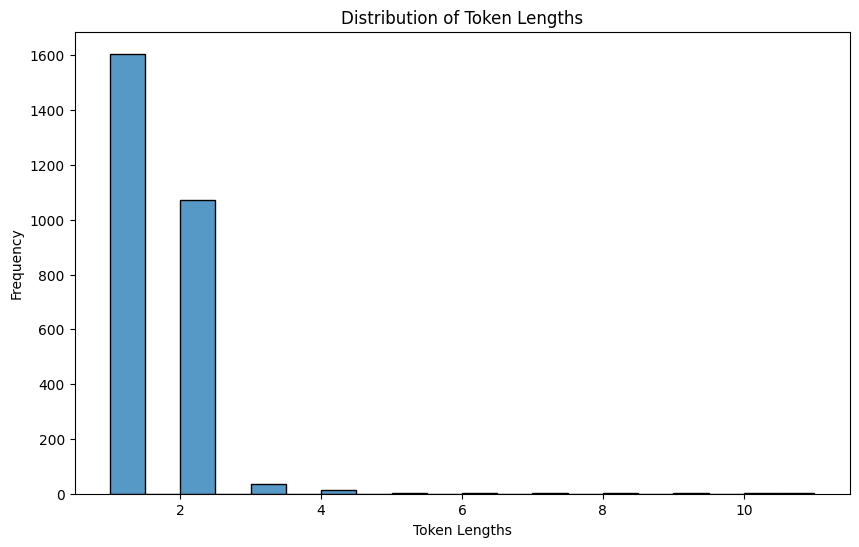

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data['lengths'], bins=20, kde=False)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Lengths')
plt.ylabel('Frequency')
plt.show()


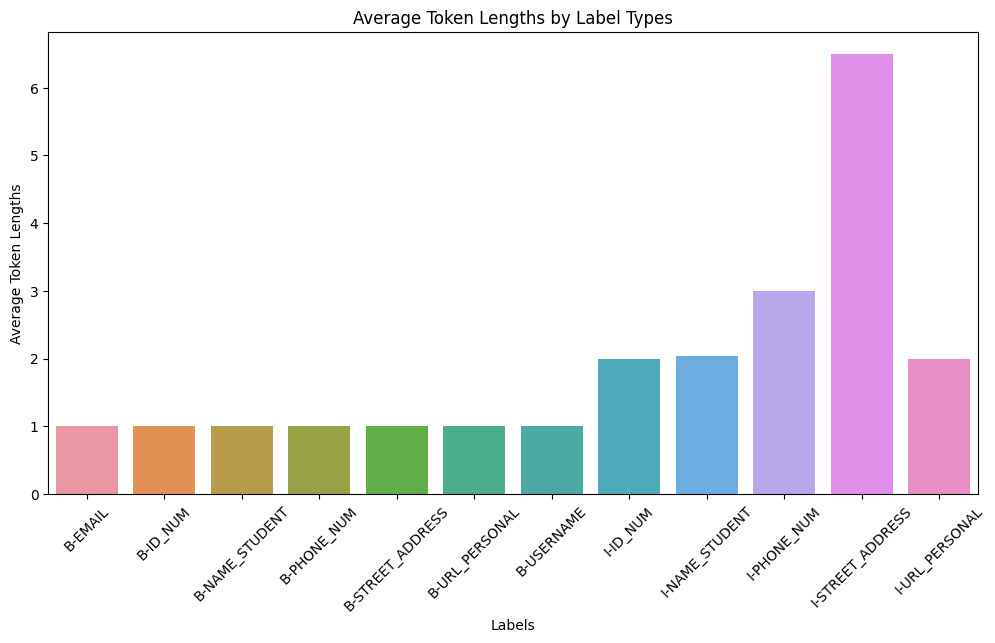

In [15]:
token_length_means = data.groupby('labels')['lengths'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='labels', y='lengths', data=token_length_means)
plt.title('Average Token Lengths by Label Types')
plt.xlabel('Labels')
plt.ylabel('Average Token Lengths')
plt.xticks(rotation=45)
plt.show()


# Most Frequently Used Tokens

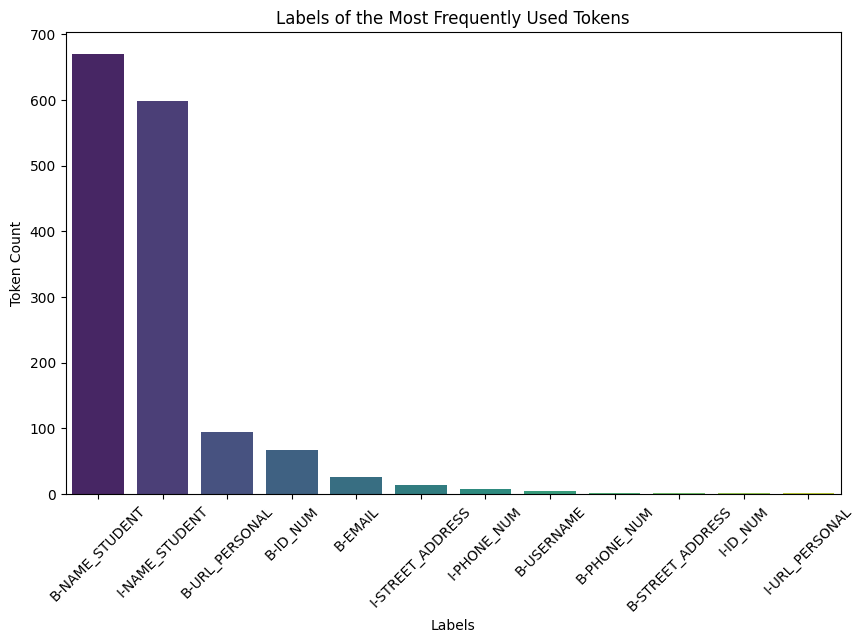

In [16]:
token_labels = data.groupby('tokens')['labels'].agg(lambda x: x.mode()[0])

label_counts = token_labels.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Labels of the Most Frequently Used Tokens')
plt.xlabel('Labels')
plt.ylabel('Token Count')
plt.xticks(rotation=45)
plt.show()


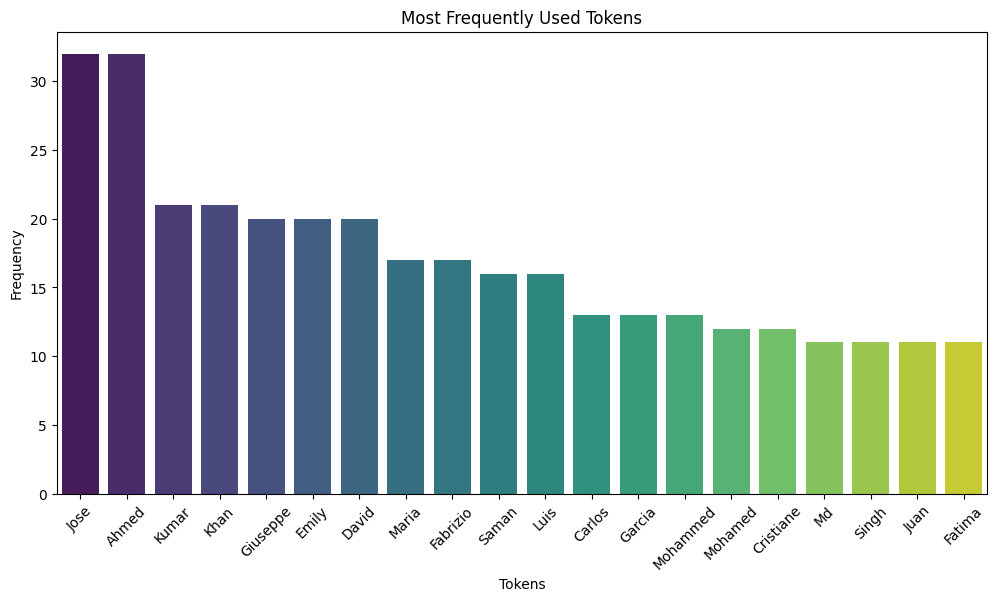

In [17]:
token_counts = data['tokens'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=token_counts.index[:20], y=token_counts.values[:20], palette='viridis')
plt.title('Most Frequently Used Tokens')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# Average Token Counts

In [18]:
def calculate_token_count(document_tokens):
    return len(document_tokens)

document_token_counts = data['tokens'].apply(lambda x: calculate_token_count(x))

average_token_count = document_token_counts.mean()

print("Average Number of Tokens in Documents:", average_token_count)


Average Number of Tokens in Documents: 7.617378605330413


B ve I etiketlerini birleştirmeden önceki veri setine göre ortalama token sayısı

In [19]:
def calculate_token_count(document_tokens):
    return len(document_tokens)

document_token_counts = length_data['tokens'].apply(lambda x: calculate_token_count(x))

average_token_count = document_token_counts.mean()

print("Average Number of Tokens in Documents:", average_token_count)


Average Number of Tokens in Documents: 13.696762141967621


B ve I etiketlerini birleştirdikten sonraki veri setine göre ortalama token sayısı

# Length_data 

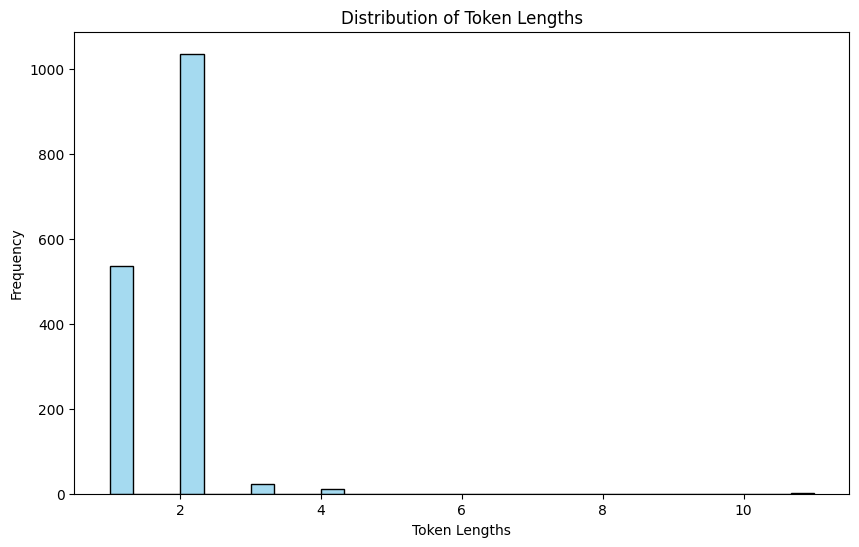

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(data=length_data, x='lengths', bins=30, kde=False, color='skyblue')
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Lengths')
plt.ylabel('Frequency')
plt.show()

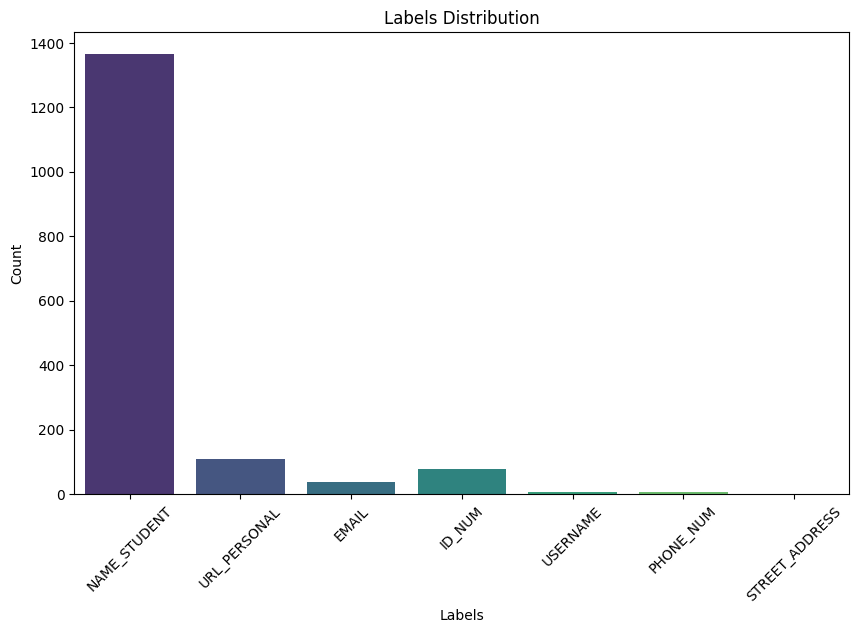

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(data=length_data, x='labels', palette='viridis')
plt.title('Labels Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Longest Tokens and Character Counts

In [22]:
# top 20 longest names
length_data[length_data['labels']=='NAME_STUDENT'].sort_values('lengths', ascending = False).head(20)

,lengths,tokens,labels
ids,,,
284,4,Aakash Kumar Aakash Kumar,NAME_STUDENT
1428,4,Pintu Kumar Ajay Rana,NAME_STUDENT
285,4,Aakash Kumar Aakash Kumar,NAME_STUDENT
735,4,Judith Van Den Heuvel,NAME_STUDENT
89,4,Sjoerd Van Der Wal,NAME_STUDENT
1153,3,Satish Kumar Zeeshan,NAME_STUDENT
375,3,Eslam Abo Fatma,NAME_STUDENT
901,3,Basavaraju Aakash Kumar,NAME_STUDENT
774,3,Om Ahmed Teto,NAME_STUDENT


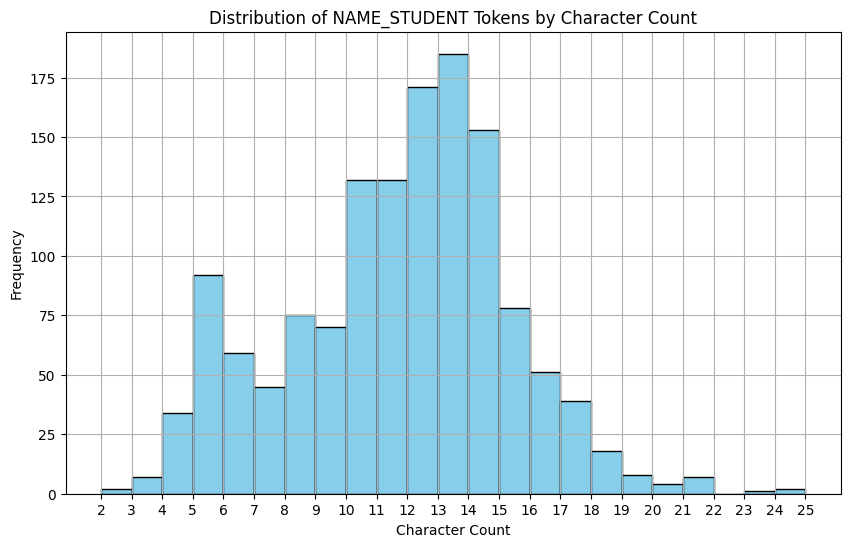

In [23]:
name_student_tokens = length_data[length_data['labels'] == 'NAME_STUDENT']

token_lengths = name_student_tokens['tokens'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=range(min(token_lengths), max(token_lengths) + 1), color='skyblue', edgecolor='black')
plt.title('Distribution of NAME_STUDENT Tokens by Character Count')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.xticks(range(min(token_lengths), max(token_lengths) + 1))
plt.grid(True)
plt.show()


In [24]:
# top 5 longest urls
length_data[length_data['labels']=='URL_PERSONAL'].sort_values('lengths', ascending = False).head(5)

,lengths,tokens,labels
ids,,,
178,2,https://www.youtube.com/channel/UC1ElAcppeuhfe...,URL_PERSONAL
23,1,https://www.jackson.com/list/explorehomepage.htm,URL_PERSONAL
1195,1,http://www.green.info/wp-content/wp-contentpos...,URL_PERSONAL
1279,1,http://hogan.com/app/categoriesindex.php,URL_PERSONAL
1258,1,https://buck-flores.com/list/postshomepage.jsp,URL_PERSONAL


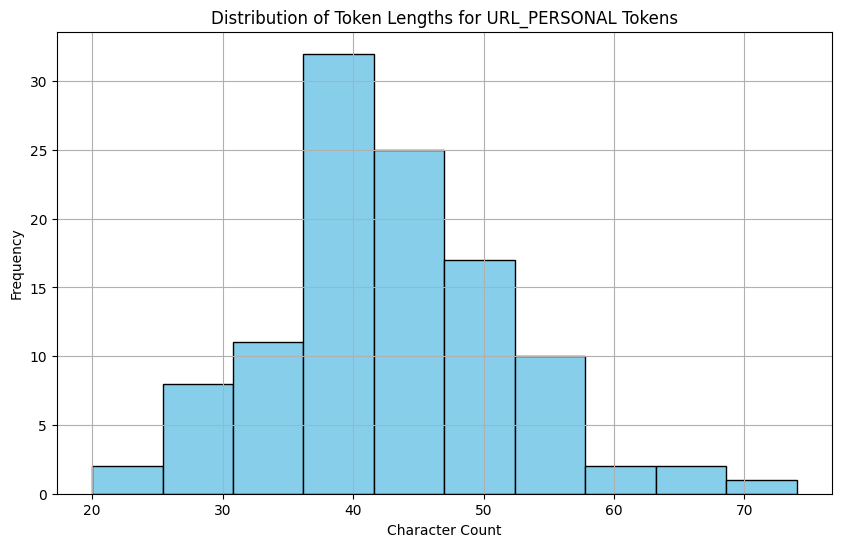

In [25]:
url_personal_tokens = length_data[length_data['labels'] == 'URL_PERSONAL']

token_lengths = url_personal_tokens['tokens'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Token Lengths for URL_PERSONAL Tokens')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [26]:
# top 5 longest emails
length_data[length_data['labels']=='EMAIL'].sort_values('lengths', ascending = False).head(5)

,lengths,tokens,labels
ids,,,
31,1,djones@gmail.com,EMAIL
1232,1,pauljohnson@hotmail.com,EMAIL
738,1,diazkristen@gmail.com,EMAIL
741,1,lisarose@gmail.com,EMAIL
742,1,diazkristen@gmail.com,EMAIL


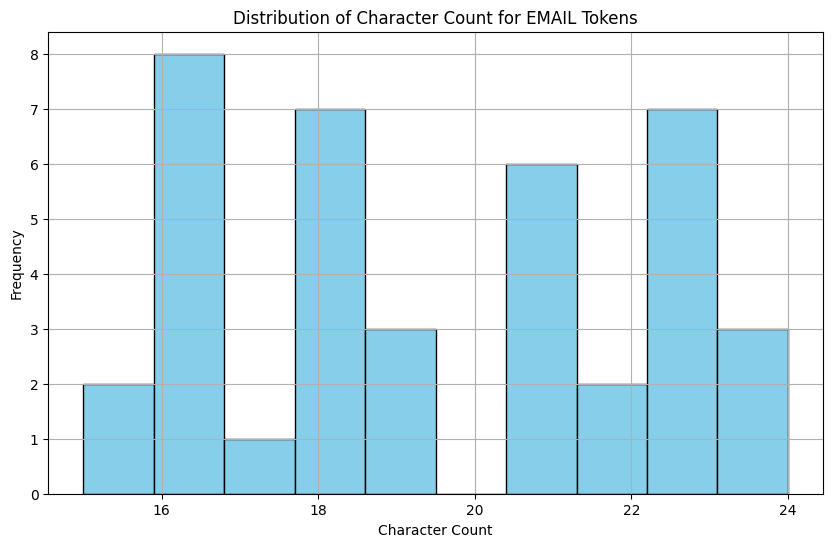

In [27]:
email_tokens = length_data[length_data['labels'] == 'EMAIL']

token_lengths = email_tokens['tokens'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Character Count for EMAIL Tokens')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [28]:
# top 5 longest ID_NUM
length_data[length_data['labels']=='ID_NUM'].sort_values('lengths', ascending = False).head(5)

,lengths,tokens,labels
ids,,,
1604,2,Z.S. 30407059,ID_NUM
40,1,860632713425,ID_NUM
978,1,nMFtUVxSUI|33529258,ID_NUM
1096,1,172801513686,ID_NUM
1076,1,183169291463,ID_NUM


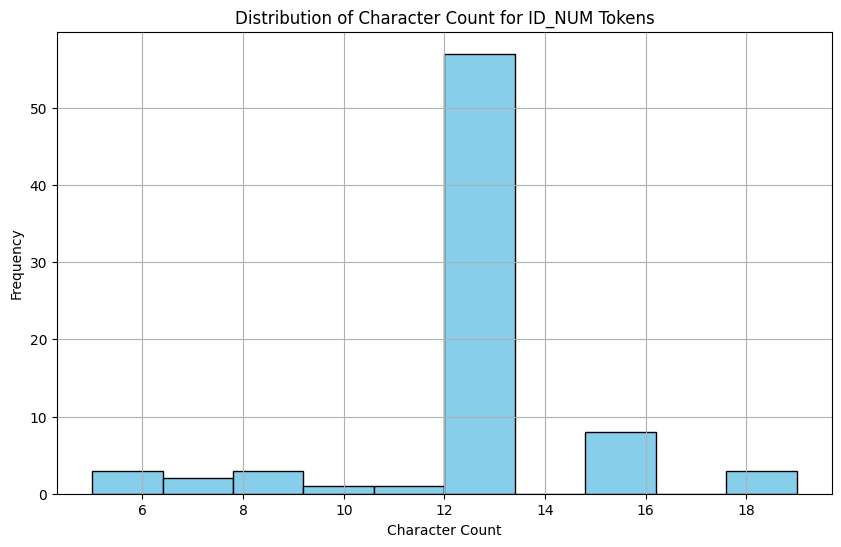

In [29]:
id_num_tokens = length_data[length_data['labels'] == 'ID_NUM']

token_lengths = id_num_tokens['tokens'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Character Count for ID_NUM Tokens')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [30]:
# top 5 longest usernames
length_data[length_data['labels']=='USERNAME'].sort_values('lengths', ascending = False).head(5)

,lengths,tokens,labels
ids,,,
195,1,castanedagabriel,USERNAME
337,1,fdixon,USERNAME
338,1,fdixon,USERNAME
509,1,meyermichelle,USERNAME
802,1,jacob59,USERNAME


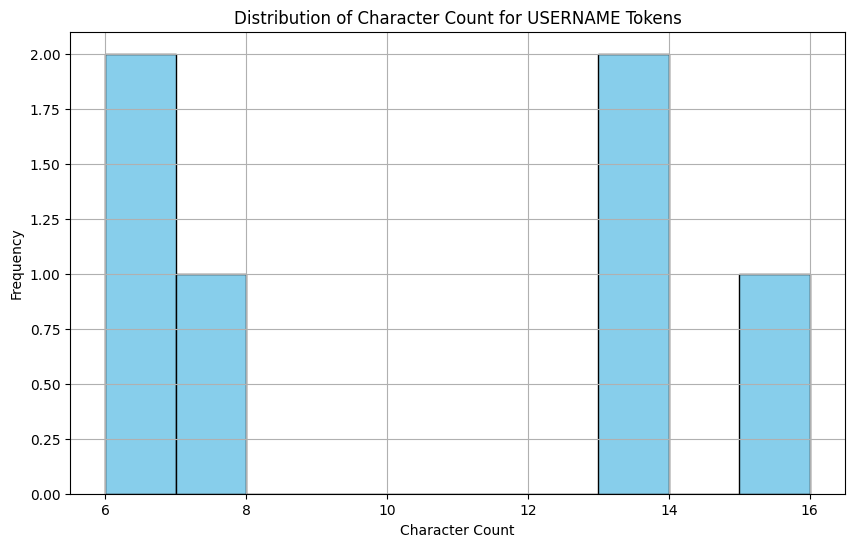

In [31]:
username_tokens = length_data[length_data['labels'] == 'USERNAME']

token_lengths = username_tokens['tokens'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Character Count for USERNAME Tokens')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [32]:
# top 10 longest phone numbers
length_data[length_data['labels']=='PHONE_NUM'].sort_values('lengths', ascending = False).head(10)

,lengths,tokens,labels
ids,,,
321,4,( 320)202 - 0688x95843,PHONE_NUM
377,4,( 223)392 - 2765,PHONE_NUM
572,4,( 820)913 - 3241x894,PHONE_NUM
575,4,( 820)913 - 3241x894,PHONE_NUM
578,4,( 820)913 - 3241x894,PHONE_NUM
1114,1,410.526.1667,PHONE_NUM


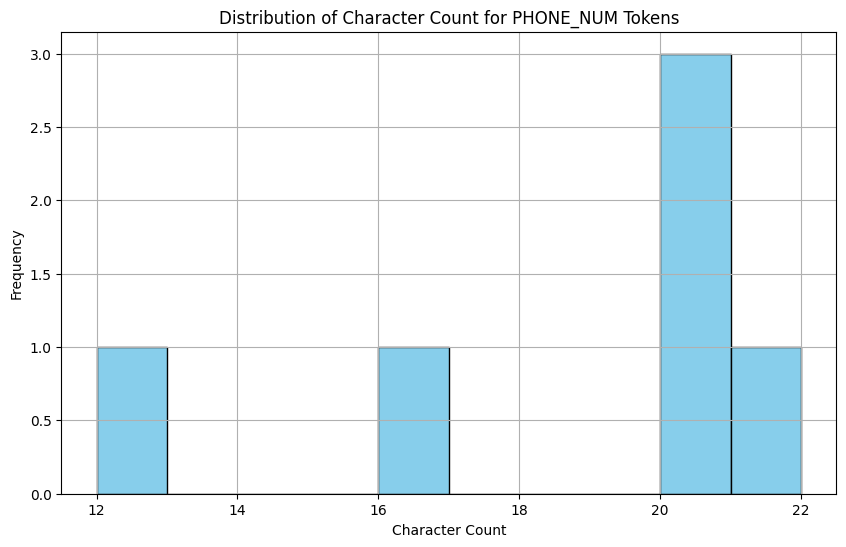

In [33]:
phone_num_tokens = length_data[length_data['labels'] == 'PHONE_NUM']

token_lengths = phone_num_tokens['tokens'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Character Count for PHONE_NUM Tokens')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [34]:
# top 10 longest address
length_data[length_data['labels']=='STREET_ADDRESS'].sort_values('lengths', ascending = False).head(10)

,lengths,tokens,labels
ids,,,
1113,11,"591 Smith Centers Apt . 656 \n Joshuamouth , R...",STREET_ADDRESS
1294,11,"743 Erika Bypass Apt . 419 \n Andreahaven , IL...",STREET_ADDRESS


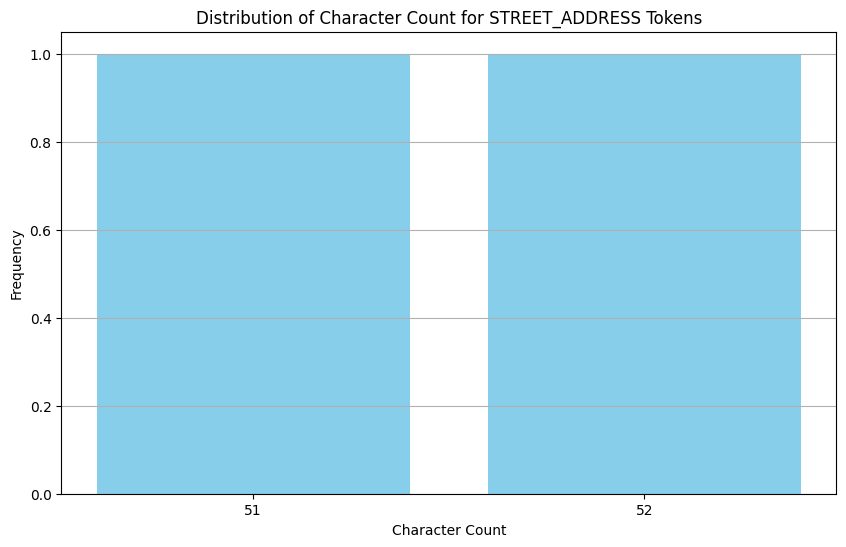

In [35]:
street_address_tokens = length_data[length_data['labels'] == 'STREET_ADDRESS']

character_lengths = street_address_tokens['tokens'].apply(len)

character_lengths_counts = character_lengths.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(character_lengths_counts.index, character_lengths_counts.values, color='skyblue')
plt.title('Distribution of Character Count for STREET_ADDRESS Tokens')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.xticks(character_lengths_counts.index)
plt.show()


**Thank you!**